In [1]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self):
    # 데이터셋의 전처리를 해주는 부분
        data = pd.read_csv('C:/Users/Soyoung Cho/Desktop/NMT Project/dataset/datalist.csv')
        #test_data = pd.read_csv('C:/Users/Soyoung Cho/Desktop/NMT Project/dataset/tatoeba_data.csv')
    
        self.Kor_data = data['Korean']
        self.Eng_data = data['English']

    def __len__(self):
    # 데이터셋의 길이. 즉, 총 샘플의 수
        return len(self.Kor_data)

    def __getitem__(self, idx):
    # 데이터셋에서 특정 1개의 샘플을 가져오는 함수.
        kor = torch.FloatTensor(self.Kor_data[idx])
        eng = torch.FloatTensor(self.Eng_data[idx])


dataset = Dataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print(dataset.Eng_data[0])
print(type(dataset.Eng_data[0]))

It is the most important thing to have creativity when we are young.
<class 'str'>


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

SOS_token = 0
EOS_token = 1

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# 유니 코드 문자열을 일반 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [5]:
# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    data = Dataset()
    #train_loader = DataLoader(test_data, batch_size=2, shuffle=True)
    
    # 파일을 읽고 줄로 분리
    pairs = []
    for i in range(1,100000):
        sentence_list = []
        normalized_kor = normalizeString(data.Kor_data[i])
        sentence_list.append(normalized_kor)
        normalized_eng = normalizeString(data.Eng_data[i])
        sentence_list.append(normalized_eng)
        pairs.append(sentence_list)
        # [[안녕, 나는, 소영이야], [hi, i, am, soyoung]] 이런 형태로 pairs
          
    print(pairs)
        
    #lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    #    read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    #pairs = [[normalizeString(s) for s in l.split('\t')] for l in sentence_list]
    

    # 쌍을 뒤집고, Lang 인스턴스 생성
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 50

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


In [8]:
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH #and \
        #p[1].startswith(eng_prefixes)

한글 문장의 단어 개수 제한, 영어 문장의 단어 개수 제한.

In [9]:
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [11]:
input_lang, output_lang, pairs = prepareData('Korean', 'English')
print(random.choice(pairs))

Reading lines...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Read 99999 sentence pairs
Trimmed to 96560 sentence pairs
Counting words...
Counted words:
Korean 307553
English 88368
['프랑스 인상파 화가 클로드 모네(1840∼1926)의 그림 한 점이 미국 뉴욕 소더비 경매에서 1억1170만 달러(약 1318억원)에 팔렸다 .', "a painting by french impressionist claude monet (1840-1926) was sold for $ 111 .7 million (about krw 131 .8 billion) at the sotheby's auction in new york, usa ."]


# 모델 코드

Pytorch tutorial (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
teacher_forcing_ratio = 0.99


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=250, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# 평가

In [20]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

30m 31s (- 580m 7s) (250 5%) 10.3217
59m 25s (- 534m 47s) (500 10%) 8.5558
87m 24s (- 495m 20s) (750 15%) 8.1278
118m 26s (- 473m 47s) (1000 20%) 7.9069
147m 43s (- 443m 9s) (1250 25%) 7.8172
176m 24s (- 411m 36s) (1500 30%) 7.6409
204m 16s (- 379m 22s) (1750 35%) 7.5181
233m 49s (- 350m 44s) (2000 40%) 7.4564
263m 24s (- 321m 56s) (2250 45%) 7.4059
290m 52s (- 290m 52s) (2500 50%) 7.3721
321m 3s (- 262m 40s) (2750 55%) 7.3313
350m 43s (- 233m 49s) (3000 60%) 7.2917
380m 18s (- 204m 46s) (3250 65%) 7.2059
408m 41s (- 175m 9s) (3500 70%) 7.1450
437m 20s (- 145m 46s) (3750 75%) 7.1166
466m 13s (- 116m 33s) (4000 80%) 7.2279
495m 31s (- 87m 26s) (4250 85%) 7.0461
524m 14s (- 58m 14s) (4500 90%) 7.0426
554m 10s (- 29m 10s) (4750 95%) 7.1005
583m 10s (- 0m 0s) (5000 100%) 6.9774


<Figure size 432x288 with 0 Axes>

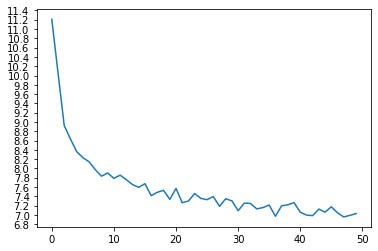

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 5000, print_every=250)

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> 그가 1989년 미국에서 출간한 ‘디스커버링(discovering)’은 위대한 과학자들의 창의성·관찰력·통찰력 등이 빛나는 순간과 발견 과정을 다룬 책으로 1990년 la타임스가 ‘올해의 책’으로 선정했다 .
= "discovering," which he published in 1989 in the u .s ., is a book about the moments of great scientists' creativity, keen observation and insight and their discovery process, and it was selected by the los angeles times as the "book of the year" in 1990 .
< the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head of the head

> 국내에서도 큰 주목을 받았던 이창동 감독의 ‘버닝’은 연말 분위기가 물씬 다가온 뉴욕에서 여전히 조용하지만 뜨겁게 뉴욕 시민들에게 다가가고 있다 .
= director lee chang-dong's "burning," which also received much attention in korea, is still reaching new yorkers quietly but hotly in new york